# 1. 데이터 준비와 확인

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from konlpy.tag import Okt

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from collections import Counter


# 데이터 파일 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 로더 구성
다음과 같은 기능을 수행하는 함수 data_load 를 정의한다.

* 데이터의 중복 제거
* 한글과 공백을 제외하고 모두 제거
* white space 데이터를 empty value로 변경
* 빈 값을 가진 행이 있다면 Null 값으로 변경
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_data['document'] = train_data['document'].str.replace('^ +', "")
    train_data['document'].replace('', np.nan, inplace=True)
    train_data = train_data.dropna(how = 'any')

    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}    # {단어:숫자} 딕셔너리 생성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

/tmp/ipykernel_637/3500571215.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_637/3500571215.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")
/tmp/ipykernel_637/3500571215.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


train data 개수: 145393, test data 개수: 48995


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
print(X_train[99])
print(get_decoded_sentence(X_train[99], index_to_word))
print('라벨: ', y_train[99])  # 100번째 리뷰데이터의 라벨

[412, 30, 6, 776, 1584, 51, 34, 3757, 59, 2, 105, 10, 30, 26]
재밌 고 새로운 에피소드 내 에서 메인 스토리 <UNK> 나오 게 재밌 음
라벨:  1


In [8]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
라벨:  0


# 3. 모델 구성을 위한 데이터 분석 및 가공

# maxlen 설정

## 정규분포 기준 3$\sigma$ 확인
* maxlen이 48로 전체 분포에 대해 약 97% 설명한다.

## 정규분포 기준 2$\sigma$ 확인
* maxlen이 36로 전체 분포에 대해 약 93% 설명한다.

In [9]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 3시그마 기준 
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('\npad_sequences maxlen : ', maxlen)
print('3시그마 기준 전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 2시그마 기준 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('\npad_sequences maxlen : ', maxlen)
print('2시그마 기준 전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.785336543408029
문장길이 최대 :  83
문장길이 표준편차 :  11.457569297538202

pad_sequences maxlen :  48
3시그마 기준 전체 문장의 0.9725600345700351%가 maxlen 설정값 이내에 포함됩니다. 

pad_sequences maxlen :  36
2시그마 기준 전체 문장의 0.9336790336852069%가 maxlen 설정값 이내에 포함됩니다. 


## Box plot 기준 Outlier 최대 기준점 확인
* maxlen이 33.5로 전체 분포에 대해 약 92% 설명한다.

In [10]:
def find_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    
    iqr = q3 - q1
    
    upper_bound = q3 + (iqr * 1.5) # Q3 + (iqr * 1.5)
    
    print('pad_sequences maxlen : ', upper_bound)
    print('2시그마 기준 전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < upper_bound) / len(num_tokens)))

find_outlier(num_tokens)

pad_sequences maxlen :  33.5
2시그마 기준 전체 문장의 0.9213583142992365%가 maxlen 설정값 이내에 포함됩니다. 


## 전체 분포 및 Box Plot 확인

Text(47, 0.58, '48')

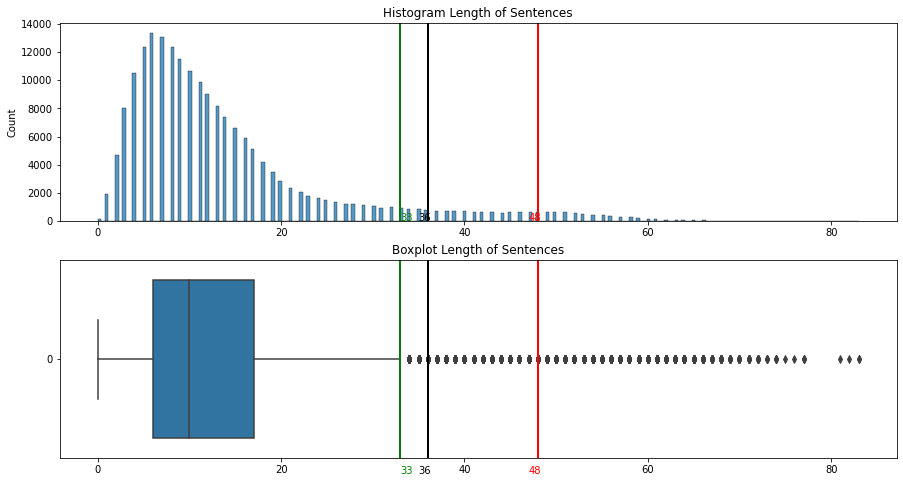

In [11]:
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
sns.histplot(num_tokens)
plt.title('Histogram Length of Sentences')

plt.axvline(x=33, color='green', linewidth=2) # boxplot 기준점
plt.text(33, 0.58, 33, color='green')
plt.axvline(x=36, color='black', linewidth=2) # 2시그마 기준점
plt.text(35, 0.58, 36, color='black')
plt.axvline(x=48, color='red', linewidth=2) # 3시그마 기준점
plt.text(47, 0.58, 48, color='red')

plt.subplot(2,1,2)
sns.boxplot(data=num_tokens, orient='h')
plt.title('Boxplot Length of Sentences')

plt.axvline(x=33, color='green', linewidth=2) # boxplot 기준점
plt.text(33, 0.58, 33, color='green')
plt.axvline(x=36, color='black', linewidth=2) # 2시그마 기준점
plt.text(35, 0.58, 36, color='black')
plt.axvline(x=48, color='red', linewidth=2) # 3시그마 기준점
plt.text(47, 0.58, 48, color='red')

# maxlen : 36 으로 설정

* 상자그림의 maxlen : 33, distribution에 대해 약 92%의 설명력을 가짐
* 2$\sigma$ 의 maxlen : 36, distribution에 대해 약 93%의 설명력을 가짐
* 3$\sigma$ 의 maxlen : 48, distribution에 대해 약 97%의 설명력을 가짐

이 값들의 분포가 3$\sigma$처럼 maxlen이 커지면 자칫 모델이 편향될 수 있다. 그렇다고 BoxPlot의 Outlier 기준점인 33으로 자른다고 해서 데이터 자체가 이상치라고 볼 수 없다. 그러므로 분포의 2$\sigma$를 취한 36개의 maxlen을 취하는 것이 합리적이며 보다 Robust하게 모델이 생성될 것으로 예상된다.

In [12]:
maxlen = 36

# padding 적용
* `keras.preprocessing.sequence.pad_sequences` 을 활용하여 패딩을 추가한다.
* padding 방식에 대해 문장 뒤쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생하는 것을 확인하기위해 두 가지 방법을 각각 적용하여 진행한다.

In [13]:
X_train_pre = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test_pre = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(145393, 36)


In [14]:
X_train_post = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test_post = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(X_train_post.shape)

(145393, 36)


In [15]:
print(X_train_pre[99])
print(get_decoded_sentence(X_train_pre[99], index_to_word))
print('라벨: ', y_train[99])  # 100번째 리뷰데이터의 라벨

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  412   30    6  776 1584   51
   34 3757   59    2  105   10   30   26]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 설정 재밌 고 새로운 에피소드 내 에서 메인 스토리 <UNK> 나오 게 재밌 음
라벨:  1


In [16]:
print(X_train_post[99])
print(get_decoded_sentence(X_train_post[99], index_to_word))
print('라벨: ', y_train[99])  # 100번째 리뷰데이터의 라벨

[ 412   30    6  776 1584   51   34 3757   59    2  105   10   30   26
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
재밌 고 새로운 에피소드 내 에서 메인 스토리 <UNK> 나오 게 재밌 음 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  1


# 4. validation set 구성 및 모델 학습

## validation set 분리

In [17]:
# validation set 10000건 분리
X_val_pre = X_train_pre[:45000]    # pre 패딩된 train set 분리
X_val_post = X_train_post[:45000]  # post 패딩된 train set 분리
y_val = y_train[:45000]

# validation set을 제외한 나머지
partial_X_train_pre = X_train_pre[45000:]
partial_X_train_post = X_train_post[45000:]
partial_y_train = y_train[45000:]


# validation set 갯수
print(X_val_pre.shape)
print(X_val_post.shape)
print(y_val.shape)

# 나머지 train set 갯수
print(partial_X_train_pre.shape)
print(partial_X_train_post.shape)
print(partial_y_train.shape)

(45000, 36)
(45000, 36)
(45000,)
(100393, 36)
(100393, 36)
(100393,)


## 모델구성
### 1. LSTM(pre, post)
### 2. GRU(pre, post)
### 3. 1-D CNN(pre, post)
### 4. GlobalMaxPooling1D(pre, post)

# 4.1 LSTM Pre

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm_pre = keras.Sequential()
model_lstm_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_pre.add(keras.layers.LSTM(8))
model_lstm_pre.add(keras.layers.Dense(8, activation='relu'))
model_lstm_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_lstm_pre.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_lstm_pre.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_lstm_pre = model_lstm_pre.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 12s 5ms/step - loss: 0.4141 - accuracy: 0.8098 - val_loss: 0.3549 - val_accuracy: 0.8414
Epoch 2/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3339 - accuracy: 0.8556 - val_loss: 0.3548 - val_accuracy: 0.8406
Epoch 3/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3030 - accuracy: 0.8693 - val_loss: 0.3478 - val_accuracy: 0.8460
Epoch 4/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2731 - accuracy: 0.8823 - val_loss: 0.3536 - val_accuracy: 0.8483
Epoch 5/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2464 - accuracy: 0.8952 - val_loss: 0.3809 - val_accuracy: 0.8469


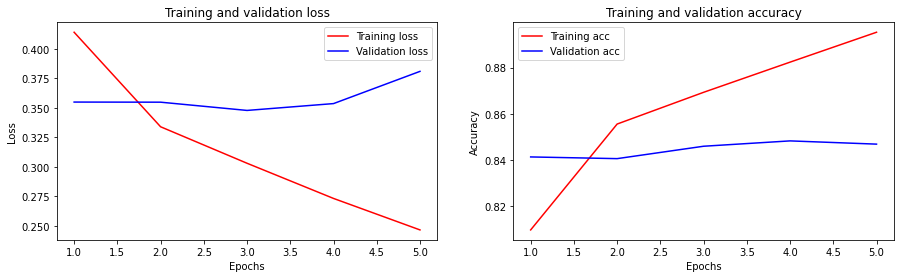

In [20]:
history_rnn_pre_result = history_lstm_pre.history

acc = history_rnn_pre_result['accuracy']
val_acc = history_rnn_pre_result['val_accuracy']
loss = history_rnn_pre_result['loss']
val_loss = history_rnn_pre_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
results = model_lstm_pre.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.3884 - accuracy: 0.8418
[0.3883804976940155, 0.8417593836784363]


# 4.2 LSTM Post

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm_post = keras.Sequential()
model_lstm_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_post.add(keras.layers.LSTM(8))
model_lstm_post.add(keras.layers.Dense(8, activation='relu'))
model_lstm_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_lstm_post.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_lstm_post.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_lstm_post = model_lstm_post.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 10s 5ms/step - loss: 0.4117 - accuracy: 0.8156 - val_loss: 0.3496 - val_accuracy: 0.8457
Epoch 2/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3217 - accuracy: 0.8616 - val_loss: 0.3408 - val_accuracy: 0.8498
Epoch 3/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2857 - accuracy: 0.8789 - val_loss: 0.3508 - val_accuracy: 0.8468
Epoch 4/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2568 - accuracy: 0.8919 - val_loss: 0.3588 - val_accuracy: 0.8480
Epoch 5/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2329 - accuracy: 0.9023 - val_loss: 0.3749 - val_accuracy: 0.8476


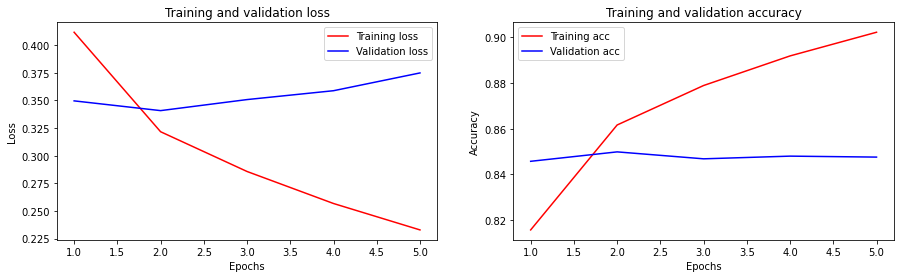

In [24]:
history_lstm_post_result = history_lstm_post.history

acc = history_lstm_post_result['accuracy']
val_acc = history_lstm_post_result['val_accuracy']
loss = history_lstm_post_result['loss']
val_loss = history_lstm_post_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
results = model_lstm_post.evaluate(X_test_post,  y_test, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.6830 - accuracy: 0.5335
[0.6829617619514465, 0.5334625840187073]


# 4.3 GRU Pre

In [26]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_gru_pre = keras.Sequential()
model_gru_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gru_pre.add(keras.layers.GRU(8))
model_gru_pre.add(keras.layers.Dense(8, activation='relu'))
model_gru_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gru_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,705
Trainable params: 160,705
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_gru_pre.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_gru_pre = model_gru_pre.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 10s 5ms/step - loss: 0.4231 - accuracy: 0.8065 - val_loss: 0.3599 - val_accuracy: 0.8415
Epoch 2/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3395 - accuracy: 0.8540 - val_loss: 0.3497 - val_accuracy: 0.8464
Epoch 3/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3082 - accuracy: 0.8701 - val_loss: 0.3432 - val_accuracy: 0.8501
Epoch 4/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2805 - accuracy: 0.8837 - val_loss: 0.3500 - val_accuracy: 0.8488
Epoch 5/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2563 - accuracy: 0.8945 - val_loss: 0.3583 - val_accuracy: 0.8478


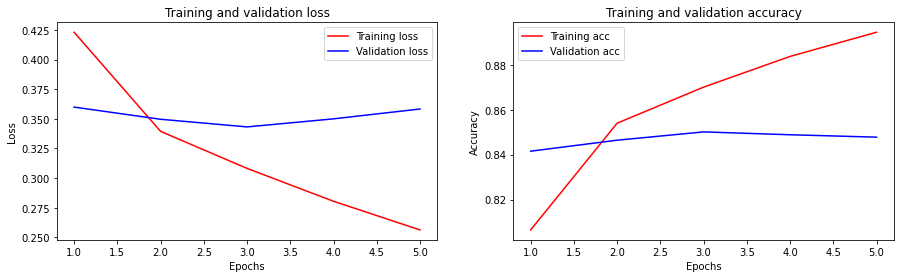

In [28]:
history_gru_pre_result = history_gru_pre.history

acc = history_gru_pre_result['accuracy']
val_acc = history_gru_pre_result['val_accuracy']
loss = history_gru_pre_result['loss']
val_loss = history_gru_pre_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
results = model_gru_pre.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.3611 - accuracy: 0.8442
[0.36109423637390137, 0.8442085981369019]


# 4.4 GRU Post

In [30]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_gru_post = keras.Sequential()
model_gru_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gru_post.add(keras.layers.LSTM(8))
model_gru_post.add(keras.layers.Dense(8, activation='relu'))
model_gru_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gru_post.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_gru_post.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_gru_post = model_gru_post.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 10s 5ms/step - loss: 0.4210 - accuracy: 0.8093 - val_loss: 0.3603 - val_accuracy: 0.8421
Epoch 2/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3390 - accuracy: 0.8535 - val_loss: 0.3513 - val_accuracy: 0.8456
Epoch 3/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.3106 - accuracy: 0.8673 - val_loss: 0.3529 - val_accuracy: 0.8441
Epoch 4/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2857 - accuracy: 0.8782 - val_loss: 0.3572 - val_accuracy: 0.8465
Epoch 5/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.2627 - accuracy: 0.8887 - val_loss: 0.3689 - val_accuracy: 0.8482


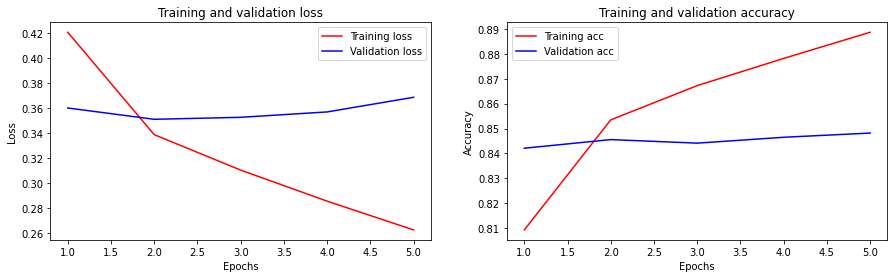

In [32]:
history_gru_post_result = history_gru_post.history

acc = history_gru_post_result['accuracy']
val_acc = history_gru_post_result['val_accuracy']
loss = history_gru_post_result['loss']
val_loss = history_gru_post_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
results = model_gru_post.evaluate(X_test_post,  y_test, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.6431 - accuracy: 0.6074
[0.6430603861808777, 0.6074497103691101]


# 4.5 1-D CNN Pre

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn_pre = keras.Sequential()
model_cnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn_pre.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_cnn_pre.add(keras.layers.MaxPooling1D(5))
model_cnn_pre.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_cnn_pre.add(keras.layers.GlobalMaxPooling1D())
model_cnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_cnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_cnn_pre.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [35]:
model_cnn_pre.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_cnn_pre = model_cnn_pre.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 9s 5ms/step - loss: 0.4878 - accuracy: 0.7461 - val_loss: 0.4187 - val_accuracy: 0.7978
Epoch 2/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.3783 - accuracy: 0.8241 - val_loss: 0.4163 - val_accuracy: 0.8022
Epoch 3/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.3204 - accuracy: 0.8557 - val_loss: 0.4422 - val_accuracy: 0.7977
Epoch 4/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2665 - accuracy: 0.8827 - val_loss: 0.4792 - val_accuracy: 0.7941
Epoch 5/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2213 - accuracy: 0.9032 - val_loss: 0.5423 - val_accuracy: 0.7862


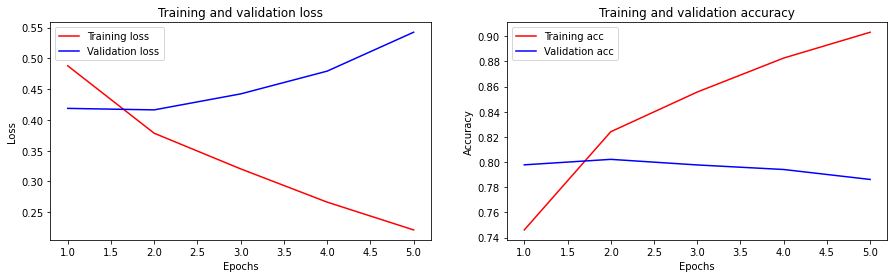

In [36]:
history_cnn_pre_result = history_cnn_pre.history

acc = history_cnn_pre_result['accuracy']
val_acc = history_cnn_pre_result['val_accuracy']
loss = history_cnn_pre_result['loss']
val_loss = history_cnn_pre_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
results = model_cnn_pre.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.5447 - accuracy: 0.7856
[0.5446504950523376, 0.7856107950210571]


# 4.6 1-D CNN Post

In [38]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn_post = keras.Sequential()
model_cnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn_post.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_cnn_post.add(keras.layers.MaxPooling1D(5))
model_cnn_post.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_cnn_post.add(keras.layers.GlobalMaxPooling1D())
model_cnn_post.add(keras.layers.Dense(8, activation='relu'))
model_cnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_cnn_post.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [39]:
model_cnn_post.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_cnn_post = model_cnn_post.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 8s 5ms/step - loss: 0.4790 - accuracy: 0.7551 - val_loss: 0.4230 - val_accuracy: 0.7955
Epoch 2/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.3770 - accuracy: 0.8252 - val_loss: 0.4165 - val_accuracy: 0.8021
Epoch 3/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.3215 - accuracy: 0.8549 - val_loss: 0.4375 - val_accuracy: 0.7988
Epoch 4/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2694 - accuracy: 0.8813 - val_loss: 0.4873 - val_accuracy: 0.7898
Epoch 5/5
1569/1569 [==============================] - 7s 5ms/step - loss: 0.2239 - accuracy: 0.9032 - val_loss: 0.5517 - val_accuracy: 0.7857


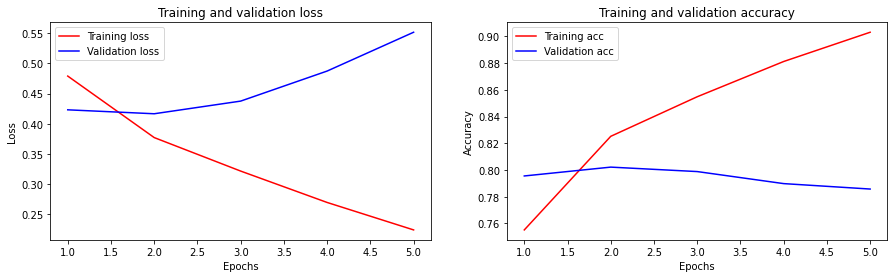

In [40]:
history_cnn_post_result = history_cnn_post.history

acc = history_cnn_post_result['accuracy']
val_acc = history_cnn_post_result['val_accuracy']
loss = history_cnn_post_result['loss']
val_loss = history_cnn_post_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
results = model_cnn_post.evaluate(X_test_post,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.4997 - accuracy: 0.7928
[0.49966686964035034, 0.7928155660629272]


# 4.7 GlobalMaxPooling1D Pre

In [42]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_maxpool_pre = keras.Sequential()
model_maxpool_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool_pre.add(keras.layers.GlobalMaxPooling1D())
model_maxpool_pre.add(keras.layers.Dense(8, activation='relu'))
model_maxpool_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_maxpool_pre.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_maxpool_pre.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_maxpool_pre = model_maxpool_pre.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 6s 3ms/step - loss: 0.4551 - accuracy: 0.7850 - val_loss: 0.3681 - val_accuracy: 0.8361
Epoch 2/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.3366 - accuracy: 0.8558 - val_loss: 0.3607 - val_accuracy: 0.8405
Epoch 3/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.2982 - accuracy: 0.8751 - val_loss: 0.3657 - val_accuracy: 0.8421
Epoch 4/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.2710 - accuracy: 0.8885 - val_loss: 0.3776 - val_accuracy: 0.8380
Epoch 5/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.2488 - accuracy: 0.9004 - val_loss: 0.3921 - val_accuracy: 0.8376


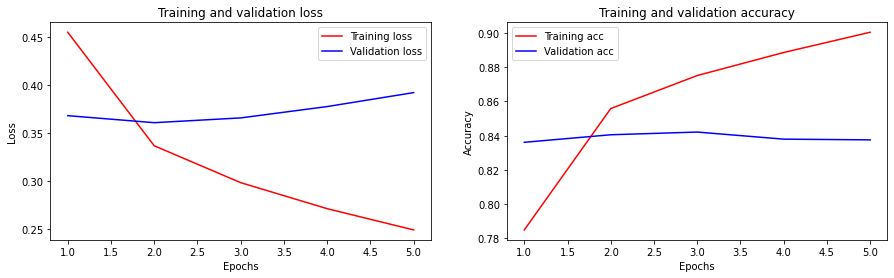

In [44]:
history_maxpool_pre_result = history_maxpool_pre.history

acc = history_maxpool_pre_result['accuracy']
val_acc = history_maxpool_pre_result['val_accuracy']
loss = history_maxpool_pre_result['loss']
val_loss = history_maxpool_pre_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [45]:
results = model_maxpool_pre.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.4060 - accuracy: 0.8319
[0.4060216248035431, 0.8319420218467712]


# 4.8 GlobalMaxPooling1D Post

In [46]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_maxpool_post = keras.Sequential()
model_maxpool_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool_post.add(keras.layers.GlobalMaxPooling1D())
model_maxpool_post.add(keras.layers.Dense(8, activation='relu'))
model_maxpool_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_maxpool_post.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_maxpool_post.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_maxpool_post = model_maxpool_post.fit(partial_X_train_pre,
                                  partial_y_train,
                                  epochs=5,
                                  batch_size=64,
                                  validation_data=(X_val_pre, y_val),
                                  verbose=1)

Epoch 1/5
1569/1569 [==============================] - 6s 3ms/step - loss: 0.4620 - accuracy: 0.7790 - val_loss: 0.3819 - val_accuracy: 0.8282
Epoch 2/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.3534 - accuracy: 0.8469 - val_loss: 0.3696 - val_accuracy: 0.8361
Epoch 3/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.3205 - accuracy: 0.8643 - val_loss: 0.3724 - val_accuracy: 0.8353
Epoch 4/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.2980 - accuracy: 0.8751 - val_loss: 0.3804 - val_accuracy: 0.8350
Epoch 5/5
1569/1569 [==============================] - 5s 3ms/step - loss: 0.2806 - accuracy: 0.8825 - val_loss: 0.3883 - val_accuracy: 0.8343


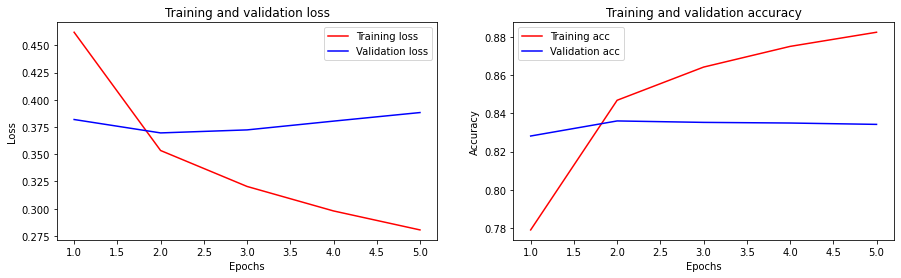

In [48]:
history_maxpool_post_result = history_maxpool_post.history

acc = history_maxpool_post_result['accuracy']
val_acc = history_maxpool_post_result['val_accuracy']
loss = history_maxpool_post_result['loss']
val_loss = history_maxpool_post_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
results = model_maxpool_post.evaluate(X_test_post,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3986 - accuracy: 0.8274
[0.39855247735977173, 0.8274313807487488]


# 5. 학습된 Embedding 레이어 분석

* model의 첫 번째 레이어는 바로 Embedding 레이어였다.
* 이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였다.
* 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것이다.

만약 우리의 감성 분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것

워드 벡터를 다루는데 유용한 gensim 패키지를 사용하여 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법으로 워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인해본다.

In [50]:
embedding_layer = model_gru_pre.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [51]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_test.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model_lstm_pre.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [52]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('놓치', 0.9780011773109436),
 ('대작', 0.9754068851470947),
 ('너희', 0.9691435694694519),
 ('아찔', 0.966591477394104),
 ('깊', 0.963537871837616),
 ('오묘', 0.9618391990661621),
 ('앍', 0.9590834379196167),
 ('히트', 0.9578129053115845),
 ('만점', 0.9563586711883545),
 ('핡', 0.9562418460845947)]

In [53]:
word_vectors.similar_by_word("기분")

[('멋진데', 0.9420783519744873),
 ('증명', 0.9243541359901428),
 ('벗어난', 0.9155787229537964),
 ('요점', 0.9113372564315796),
 ('한류', 0.9082077741622925),
 ('당위', 0.9076851010322571),
 ('떠오름', 0.8967214822769165),
 ('노아', 0.896207332611084),
 ('쏟아지', 0.8947845101356506),
 ('안구', 0.8916566371917725)]

In [54]:
word_vectors.similar_by_word("피곤")

[('그만', 0.9749100208282471),
 ('부자연', 0.9748069047927856),
 ('아까워', 0.9734141230583191),
 ('별반', 0.9732133150100708),
 ('인내력', 0.9725671410560608),
 ('망한', 0.9720989465713501),
 ('다수', 0.971389889717102),
 ('실망', 0.971350908279419),
 ('어색', 0.9704569578170776),
 ('그나마', 0.9703726768493652)]

### 다소 부자연스럽다.

* 위의 훈련데이터만으로는 word vector를 정교하게 학습시키기 어렵다.

* 따라서 더 좋은 모델의 성능을 위해서는 한국어 Word2Vec 임베딩 활용한 성능개선이 필요하다.

# 6. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [ ]:
pip install --upgrade gensim==3.8.3

In [55]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_637/1005516468.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


(200,)

In [56]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_637/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [57]:
word2vec.similar_by_word("지루")

/tmp/ipykernel_637/4116297719.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("지루")


[('답답', 0.7367106676101685),
 ('편안', 0.7046725749969482),
 ('솔직', 0.689364492893219),
 ('쓸쓸', 0.6880695819854736),
 ('차분', 0.6868932247161865),
 ('조용', 0.6765609383583069),
 ('냉정', 0.6706622838973999),
 ('자유분방', 0.6680829524993896),
 ('피곤', 0.6597293019294739),
 ('느긋', 0.659047544002533)]

In [58]:
word2vec.similar_by_word("피곤")

/tmp/ipykernel_637/1783528530.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("피곤")


[('지루', 0.6597292423248291),
 ('거만', 0.6573756337165833),
 ('조용', 0.6500644087791443),
 ('난폭', 0.64898681640625),
 ('지저분', 0.6316137313842773),
 ('무뚝뚝', 0.6290295124053955),
 ('소심', 0.6229598522186279),
 ('나약', 0.620331883430481),
 ('인색', 0.6179662942886353),
 ('교만', 0.6142992973327637)]

* Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 서로 가깝게 제대로 학습된 것을 확인할 수 있다.

* 정확하다, 비슷하다 라는 느낌보다는 확실히 성능적으로 보았을때 좋다라는것이 느껴짐.

* 이제 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 모델을 학습시킨다.

In [60]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_637/3778977091.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_637/3778977091.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [70]:
# LSTM 레이어로 모델 설계
model_ko = keras.Sequential()
model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(keras.layers.GRU(128))  # LSTM state 벡터의 차원수 (변경가능)
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_ko.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 36, 200)           2000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               126720    
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 2,127,761
Trainable params: 2,127,761
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history_ko = model_ko.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1569/1569 [==============================] - 11s 6ms/step - loss: 0.4115 - accuracy: 0.8054 - val_loss: 0.3353 - val_accuracy: 0.8528
Epoch 2/5
1569/1569 [==============================] - 9s 6ms/step - loss: 0.3023 - accuracy: 0.8705 - val_loss: 0.3335 - val_accuracy: 0.8588
Epoch 3/5
1569/1569 [==============================] - 9s 6ms/step - loss: 0.2573 - accuracy: 0.8921 - val_loss: 0.3334 - val_accuracy: 0.8586
Epoch 4/5
1569/1569 [==============================] - 10s 6ms/step - loss: 0.2151 - accuracy: 0.9125 - val_loss: 0.3698 - val_accuracy: 0.8535
Epoch 5/5
1569/1569 [==============================] - 9s 6ms/step - loss: 0.1741 - accuracy: 0.9312 - val_loss: 0.3909 - val_accuracy: 0.8538


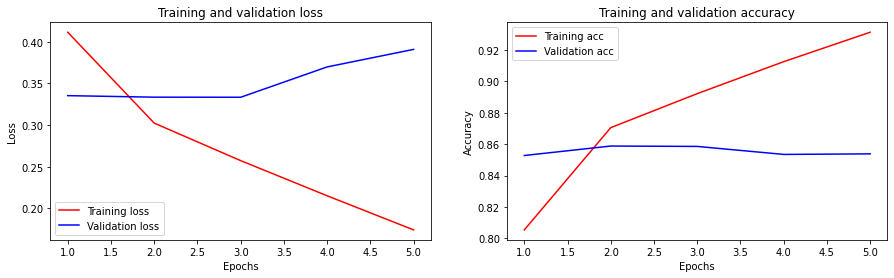

In [72]:
history_ko_gru_pre_result = history_ko.history

acc = history_ko_gru_pre_result['accuracy']
val_acc = history_ko_gru_pre_result['val_accuracy']
loss = history_ko_gru_pre_result['loss']
val_loss = history_ko_gru_pre_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [73]:
results = model_ko.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1532/1532 - 3s - loss: 0.3934 - accuracy: 0.8504
[0.3934141993522644, 0.8503520488739014]


# DropOut 적용하여 성능 개선

In [86]:
# LSTM 레이어로 모델 설계
model_ko = keras.Sequential()
model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(keras.layers.GRU(128, dropout=0.3))  # LSTM state 벡터의 차원수 (변경가능)
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_ko.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 36, 200)           2000000   
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               126720    
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 2,127,761
Trainable params: 2,127,761
Non-trainable params: 0
_________________________________________________________________


In [87]:
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history_ko = model_ko.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
1569/1569 [==============================] - 11s 6ms/step - loss: 0.4555 - accuracy: 0.7781 - val_loss: 0.3613 - val_accuracy: 0.8396
Epoch 2/5
1569/1569 [==============================] - 10s 6ms/step - loss: 0.3483 - accuracy: 0.8451 - val_loss: 0.3278 - val_accuracy: 0.8551
Epoch 3/5
1569/1569 [==============================] - 10s 6ms/step - loss: 0.3130 - accuracy: 0.8621 - val_loss: 0.3278 - val_accuracy: 0.8582
Epoch 4/5
1569/1569 [==============================] - 10s 6ms/step - loss: 0.2894 - accuracy: 0.8743 - val_loss: 0.3246 - val_accuracy: 0.8613
Epoch 5/5
1569/1569 [==============================] - 10s 6ms/step - loss: 0.2711 - accuracy: 0.8843 - val_loss: 0.3257 - val_accuracy: 0.8608


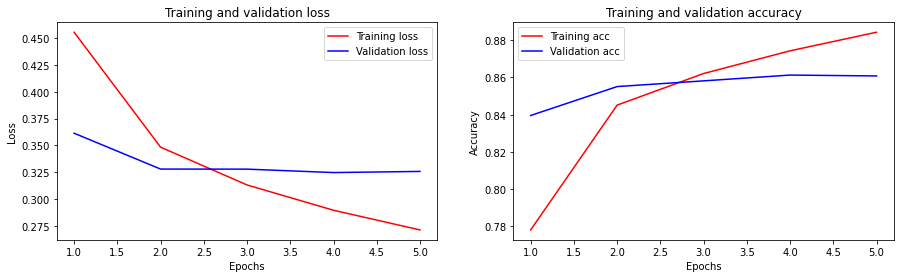

In [88]:
history_ko_gru_pre_result = history_ko.history

acc = history_ko_gru_pre_result['accuracy']
val_acc = history_ko_gru_pre_result['val_accuracy']
loss = history_ko_gru_pre_result['loss']
val_loss = history_ko_gru_pre_result['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [89]:
results = model_ko.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1532/1532 - 3s - loss: 0.3299 - accuracy: 0.8582
[0.3299327492713928, 0.858210027217865]


# 모델별 학습 결과

| 모델 | pre 패딩 | post 패딩 |
| :---: | :---: | :---: |
| LSTM | 84.179% | 53.35% |
| GRU | 84.42% | 60.74% |
| 1-D CNN | 78.56% | 79.28% |
| GlobalMaxPooling1D | 83.19% | 82.74% |

위 과정은 다양한 전처리 작업 및 maxlen을 적절하게 구했다. 이후 pre padding 및 post padding 적용을 나누어 사용하였다. LMS노드에서 pre padding을 하면 성능이 좋다고 했는데, 이를 검증하기 위해서 각 모델별로 나누어 적용했다.

* 위 모델을 볼때 GRU 모델을 적용 및 pre padding을 적용한 정확도가 84.42%로 가장 높음.
* pre padding과 post padding 적용을 비교해볼때, pre padding의 정확도가 전체적으로 높다.
* 1-D CNN와 GlobalMaxPooling1D는 별로 차이가 없지만, LSTM과 GRU를 적용했을 때 큰 차이가 난다.
* 또한 모델들이 전체적으로 과적합의 양상을 띄고 있다.

# 학습된 Embedding 레이어 분석 결과


워드 벡터를 다루는데 유용한 gensim 패키지를 사용하여 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법으로 워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하고 비교해보았다.

* 결과적으로 학습된 Embedding 레이어가 다소 부자연 스럽다.



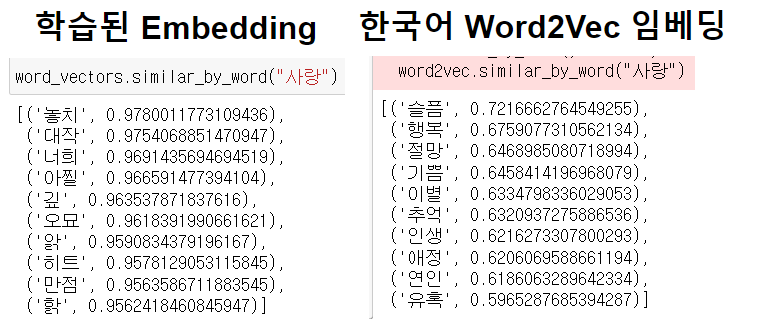

# 한국어 Word2Vec 임베딩 활용 결과

|  | Loss | accuracy |
| :---: | :---: | :---: |
| Word2Vec 결과 | 0.3934 | 0.8504 |
| Dropout 적용 결과 | 0.3299 | 0.8582 |

* 최종적으로 한국어 Word2Vec 임베딩 결과 85.04%의 정확도가 나옴.
* 규제기법인 Dropout 적용시 85.82%로 다소 성능이 향상되었다.
* 직접 설계한 임베딩보다 과적합이 상대적으로 감소했다.

# 개인적인 추가 생각

### 용어 정리의 필요성

* NLP던 CV던 중요하게 드는 생각이 용어의 정리이다.
* 용어자체의 정의를 제대로 하지않고 넘어간 경향이 없지않아 존재했기 때문에 노드진행이 상당히 어려웠고 반성해야 한다.
* 용어 및 기능들을 정리해야겠다... + 텍스트 전처리

### 하이퍼 파라미터에 대한 경험 부재

* 오늘 기본적으로 4개의 모델에 대해 학습을 진행했지만 아이러니하게 모델에대한 제대로된 이해가 부족해서 어떤 하이퍼 파라미터를 추가해야할지, 또는 추가하더라도 성능이 이상하게 나온 부분이 있다.
* 이러한 수치나 학습결과가 발생하는 문제는 데이터도 데이터지만 근본적으로 다양한 하이퍼 파라미터를 어떻게 설정하느냐에 따라 결과수치가 급격하게 달라진다.